## Safe Online (EDA)

In [25]:
# --- Load Libraries ---
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import re

from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    StackingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

# --- Load Data ---
df = pd.read_csv("dataset.csv")

# # --- Quick Overview ---
print("Shape:", df.shape)
print("\nColumns:", df.columns)


Shape: (2403, 57)

Columns: Index(['Ad ID', 'Ad Title', 'Description', 'Category ID', 'Category Name',
       'Language', 'Published At', 'Channel ID', 'Channel Title', 'Tags',
       'Tag Count', 'Live Broadcast Content', 'Localized Title',
       'Localized Description', 'Duration (raw)', 'Duration (seconds)',
       'Dimension', 'Definition', 'Projection', 'Licensed Content',
       'Captions Available', 'View Count', 'Like Count', 'Comment Count',
       'Favorite Count', 'Engagement: Like Ratio', 'Engagement: Comment Rate',
       'Upload Status', 'Privacy Status', 'License', 'Embeddable',
       'Public Stats Viewable', 'Topic Categories', 'Recording Date',
       'Location (lat/long)', 'Location Description', 'Embed HTML',
       'Embed Height', 'Embed Width', 'Scheduled Start', 'Actual Start',
       'Actual End', 'Concurrent Viewers', 'Active Live Chat ID',
       'Thumbnail Default', 'Thumbnail Medium', 'Thumbnail High',
       'Thumbnail Standard', 'Thumbnail MaxRes', 'Count

In [26]:
# --- Summary Statistics ---
print("\nSummary Statistics:\n", df.describe(include='all'))


Summary Statistics:
               Ad ID                      Ad Title  \
count          2403                          2403   
unique         2403                          2315   
top     09cOeQmF0HA  30% отстъпка с код JUSTAPP30   
freq              1                             5   
mean            NaN                           NaN   
std             NaN                           NaN   
min             NaN                           NaN   
25%             NaN                           NaN   
50%             NaN                           NaN   
75%             NaN                           NaN   
max             NaN                           NaN   

                                              Description  Category ID  \
count                                                1838  2403.000000   
unique                                               1773          NaN   
top     🔥 "MẸ VẮNG NHÀ, BA LÀ SIÊU NHÂN 2025" với sự t...          NaN   
freq                                         

c:\Users\GNG\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [27]:
unique_counts = df.nunique()

print("Unique counts per column:\n")
print(unique_counts)

Unique counts per column:

Ad ID                       2403
Ad Title                    2315
Description                 1773
Category ID                   15
Category Name                 15
Language                      68
Published At                2398
Channel ID                  1750
Channel Title               1734
Tags                         815
Tag Count                      1
Live Broadcast Content         1
Localized Title             2315
Localized Description       1773
Duration (raw)               397
Duration (seconds)           397
Dimension                      1
Definition                     2
Projection                     1
Licensed Content               2
Captions Available             2
View Count                  2347
Like Count                   808
Comment Count                363
Favorite Count                 1
Engagement: Like Ratio      1824
Engagement: Comment Rate     951
Upload Status                  1
Privacy Status                 2
License         

In [28]:
# # --- Missing Values ---
missing = df.isnull().sum()
print("\nMissing values per column:\n", missing)


Missing values per column:
 Ad ID                          0
Ad Title                       0
Description                  565
Category ID                    0
Category Name                  0
Language                     552
Published At                   0
Channel ID                     0
Channel Title                  0
Tags                           0
Tag Count                      0
Live Broadcast Content         0
Localized Title                0
Localized Description        565
Duration (raw)                 0
Duration (seconds)             0
Dimension                      0
Definition                     0
Projection                     0
Licensed Content               0
Captions Available             0
View Count                     0
Like Count                    81
Comment Count                272
Favorite Count                 0
Engagement: Like Ratio        81
Engagement: Comment Rate     273
Upload Status                  0
Privacy Status                 0
License       

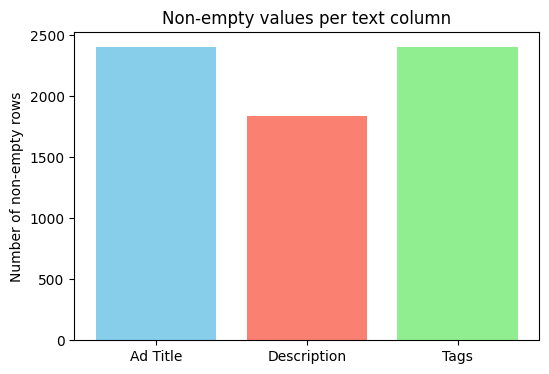

In [29]:
# Count non-empty values
counts = {
    'Ad Title': df['Ad Title'].notna().sum(),
    'Description': df['Description'].notna().sum(),
    'Tags': df['Tags'].notna().sum()
}

# Plot
plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel("Number of non-empty rows")
plt.title("Non-empty values per text column")
plt.show()


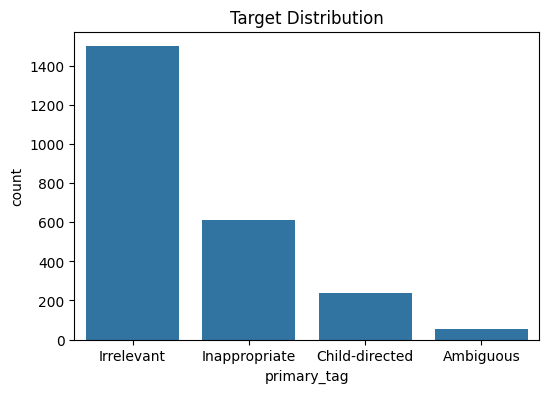

In [30]:
# --- Target Distribution (if labeled data) ---
if 'primary_tag' in df.columns:  # replace 'target' with your label column name
    plt.figure(figsize=(6,4))
    sns.countplot(x='primary_tag', data=df)
    plt.title("Target Distribution")
    plt.show()

In [31]:
columns_to_drop = [
    'Category ID',
    'Duration (raw)',
    'Published At',# not needed
    'Dimension', 'Projection',
    'Tag Count', 'Live Broadcast Content', 'Localized Title',
    'Localized Description', 'Favorite Count', 'Upload Status', 'Recording Date'
    , 'Embed HTML', 'Embed Height', 'Embed Width', 'Scheduled Start', 'Actual Start'
    ,'Actual End', 'Concurrent Viewers', 'Active Live Chat ID',
       'Thumbnail Default', 'Thumbnail Medium', 'Thumbnail High',
       'Thumbnail Standard', 'Thumbnail MaxRes', 'secondary_tag', 'Ad ID'
    ,'Channel ID', 'Channel Title', 'Location (lat/long)', 'Location Description'
    , 'SkipDuration', 'Definition', 'Ad Title', 'Description', 'Tags', 'Captions Available',
    'View Count', 'Like Count', 'Comment Count', 'Engagement: Like Ratio', 'Engagement: Comment Rate',
    'Privacy Status', 'License', 'Embeddable', 'Public Stats Viewable', 'Topic Categories',
    'Skippable', 'Advertiser Name', 'Licensed Content', 'Duration (seconds)'
]

df = df.drop(columns=columns_to_drop)
print("\nColumns:", df.columns)


Columns: Index(['Category Name', 'Language', 'Country', 'Advertiser Location',
       'Verified', 'primary_tag'],
      dtype='object')


In [32]:
unique_counts = df.nunique()

print("Unique counts per column:\n")
print(unique_counts)

Unique counts per column:

Category Name          15
Language               68
Country                30
Advertiser Location    88
Verified                2
primary_tag             4
dtype: int64


## Cleaning

In [33]:
# Drop rows with primary_tag = "Ambiguous"
df = df[df['primary_tag'] != 'Ambiguous'].copy()
df['target'] = df['primary_tag'].apply(lambda x: 1 if x == 'Inappropriate' else 0)
# Check remaining unique values
print(df['primary_tag'].unique())
df = df.drop(columns=['primary_tag'])

# Identify list-type columns
list_cols = df.select_dtypes(include='object').columns  # roughly
for col in list_cols:
    if df[col].apply(lambda x: isinstance(x, list)).any():
        df[col] = df[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)
        
        
country_to_quartile = {
    # North America
    'United States': 'Quartile A',
    'Sweden': 'Quartile A',
    'Taiwan': 'Quartile A',
    'Singapore': 'Quartile A',
    'South Korea': 'Quartile A',
    'Germany': 'Quartile A',
    'Spain': 'Quartile A',
    'Canada': 'Quartile A',
    
    'UAE': 'Quartile B',
    'France': 'Quartile B',
    'Belgium': 'Quartile B',
    'Vietnam': 'Quartile B',
    'Ireland': 'Quartile B',
    'Mexico': 'Quartile B',
    'Turkey': 'Quartile B',
    'Pakistan': 'Quartile B',
    
    'Bahrain': 'Quartile C',
    'Lebanon': 'Quartile C',
    'Lithuania': 'Quartile C',
    'Latvia': 'Quartile C',
    'Netherlands': 'Quartile C',
    'Austria': 'Quartile C',
    'Estonia': 'Quartile C',
    'Morocco': 'Quartile C',
    
    'Bulgaria': 'Quartile D',
    'Algeria': 'Quartile D',
    'Jordan': 'Quartile D',
    'Sri Lanka': 'Quartile D',
    'Bangladesh': 'Quartile D',
    'Senegal': 'Quartile D',
    'Ghana': 'Quartile D',
    'Mozambique': 'Quartile D',
}

# Apply the mapping
df['Quartile'] = df['Country'].map(country_to_quartile)

lang_mapping = {
    'en': 'English', 'fr': 'French', 'de': 'German', 'es': 'Spanish',
    'zh': 'Chinese', 'hi': 'Hindi', 'bn': 'Bengali', 'ta': 'Tamil',
    'kn': 'Kannada', 'te': 'Telugu', 'ur': 'Urdu', 'ml': 'Malayalam',
    'or': 'Odia', 'pa': 'Punjabi', 'mr': 'Marathi', 'ne': 'Nepali',
    'sv': 'Swedish', 'nl': 'Dutch', 'sq': 'Albanian', 'ar': 'Arabic',
    'tr': 'Turkish', 'vi': 'Vietnamese', 'uk': 'Ukrainian', 'th': 'Thai',
    'it': 'Italian', 'ru': 'Russian', 'lv': 'Latvian', 'ca': 'Catalan',
    'id': 'Indonesian', 'fa': 'Persian', 'el': 'Greek', 'hy': 'Armenian',
    'zxx': 'No linguistic content', 'und': 'Unknown', '':'Unknown'
}

# Apply mapping (use first two letters)
df['Language_Group'] = df['Language'].str[:2].map(lang_mapping).fillna('Other')

df = df.drop(columns=['Language'])

# Select numeric columns
num_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns

# Replace NaNs with mean
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.mean()))


['Irrelevant' 'Inappropriate' 'Child-directed']


In [34]:
df.iloc[1]
print("Shape:", df.shape)
print("\nColumns:", df.columns)

print(df.dtypes)


Shape: (2348, 7)

Columns: Index(['Category Name', 'Country', 'Advertiser Location', 'Verified', 'target',
       'Quartile', 'Language_Group'],
      dtype='object')
Category Name          object
Country                object
Advertiser Location    object
Verified                 bool
target                  int64
Quartile               object
Language_Group         object
dtype: object


In [35]:
unique_counts = df.nunique()

print("Unique counts per column:\n")

print(unique_counts)

Unique counts per column:

Category Name          15
Country                30
Advertiser Location    88
Verified                2
target                  2
Quartile                4
Language_Group         32
dtype: int64


# 1 hot encode

In [36]:
# Identify object columns
object_cols = df.select_dtypes(include='object').columns.tolist()
cols_to_encode = [col for col in object_cols if col != 'target']

df_encoded = pd.get_dummies(df, columns=cols_to_encode, dummy_na=False)

# Check result
print(df_encoded.shape)

(2348, 171)


# Trying to understand sparsity

In [37]:
overall_sparsity = (df_encoded == 0).sum().sum() / (df_encoded.shape[0] * df_encoded.shape[1])
print(f"Overall sparsity: {overall_sparsity:.2%}")

Overall sparsity: 96.43%


Advertiser Location_Luxembourg        0.999574
Advertiser Location_Uzbekistan        0.999574
Advertiser Location_Slovakia          0.999574
Advertiser Location_Senegal           0.999574
Advertiser Location_Rwanda            0.999574
Advertiser Location_Macao             0.999574
Advertiser Location_Peru              0.999574
Advertiser Location_Azerbaijan        0.999574
Advertiser Location_Palestine         0.999574
Advertiser Location_Cameroon          0.999574
Advertiser Location_Cayman Islands    0.999574
Language_Group_Marathi                0.999574
Language_Group_Nepali                 0.999574
Language_Group_Odia                   0.999574
Advertiser Location_Curaçao           0.999574
Language_Group_Persian                0.999574
Advertiser Location_Gibraltar         0.999574
Advertiser Location_Iceland           0.999574
Advertiser Location_Iraq              0.999574
Advertiser Location_Kazakhstan        0.999574
dtype: float64


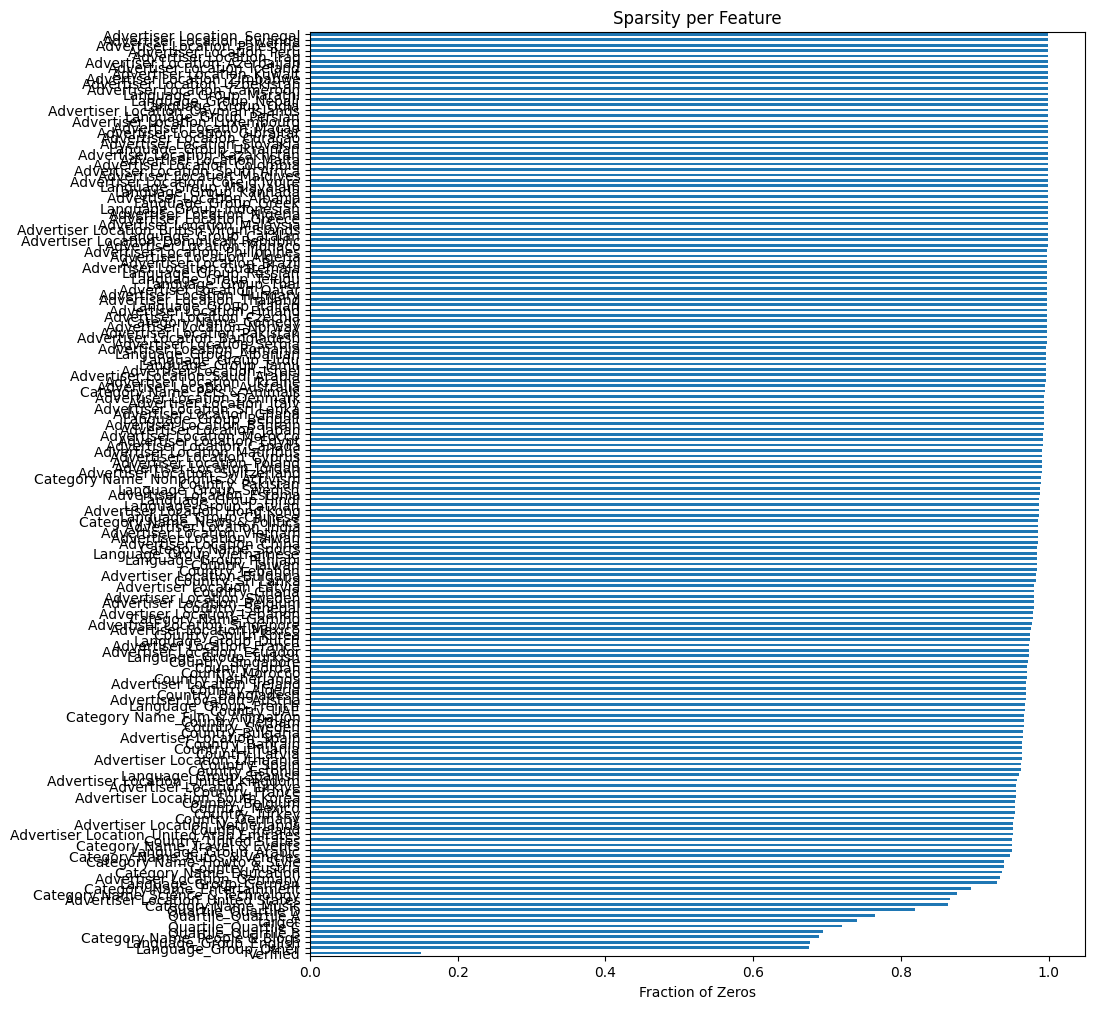

In [38]:
sparsity_per_col = (df_encoded == 0).sum() / len(df_encoded)
print(sparsity_per_col.sort_values(ascending=False).head(20))  # top 20 most sparse

plt.figure(figsize=(12,6))
sparsity_per_col.sort_values().plot(kind='barh', figsize=(10,12))
plt.title("Sparsity per Feature")
plt.xlabel("Fraction of Zeros")
plt.show()


In [39]:
to_drop = sparsity_per_col[sparsity_per_col > 0.99].index

print("Dropping columns:", list(to_drop))

# Drop them
df_encoded = df_encoded.drop(columns=to_drop)
df_encoded.shape

overall_sparsity = (df_encoded == 0).sum().sum() / (df_encoded.shape[0] * df_encoded.shape[1])
print(f"Overall sparsity: {overall_sparsity:.2%}")

Dropping columns: ['Category Name_Comedy', 'Category Name_Pets & Animals', 'Advertiser Location_Albania', 'Advertiser Location_Algeria', 'Advertiser Location_Australia', 'Advertiser Location_Azerbaijan', 'Advertiser Location_Bahrain', 'Advertiser Location_Bangladesh', 'Advertiser Location_Brazil', 'Advertiser Location_British Virgin Islands', 'Advertiser Location_Cameroon', 'Advertiser Location_Canada', 'Advertiser Location_Cayman Islands', 'Advertiser Location_Colombia', 'Advertiser Location_Curaçao', 'Advertiser Location_Cyprus', 'Advertiser Location_Czechia', 'Advertiser Location_Côte d’Ivoire', 'Advertiser Location_Denmark', 'Advertiser Location_Dominican Republic', 'Advertiser Location_Egypt', 'Advertiser Location_Finland', 'Advertiser Location_Ghana', 'Advertiser Location_Gibraltar', 'Advertiser Location_Greece', 'Advertiser Location_Guatemala', 'Advertiser Location_Hungary', 'Advertiser Location_Iceland', 'Advertiser Location_Iraq', 'Advertiser Location_Israel', 'Advertiser Loca

Boolean columns: ['Verified', 'Category Name_Autos & Vehicles', 'Category Name_Education', 'Category Name_Entertainment', 'Category Name_Film & Animation', 'Category Name_Gaming', 'Category Name_Howto & Style', 'Category Name_Music', 'Category Name_News & Politics', 'Category Name_Nonprofits & Activism', 'Category Name_People & Blogs', 'Category Name_Science & Technology', 'Category Name_Sports', 'Category Name_Travel & Events', 'Country_Algeria', 'Country_Austria', 'Country_Bahrain', 'Country_Bangladesh', 'Country_Belgium', 'Country_Bulgaria', 'Country_Estonia', 'Country_France', 'Country_Germany', 'Country_Ghana', 'Country_Ireland', 'Country_Jordan', 'Country_Latvia', 'Country_Lebanon', 'Country_Lithuania', 'Country_Mexico', 'Country_Morocco', 'Country_Netherlands', 'Country_Pakistan', 'Country_Senegal', 'Country_Singapore', 'Country_South Korea', 'Country_Spain', 'Country_Sri Lanka', 'Country_Sweden', 'Country_Taiwan', 'Country_Turkey', 'Country_UAE', 'Country_United States', 'Count

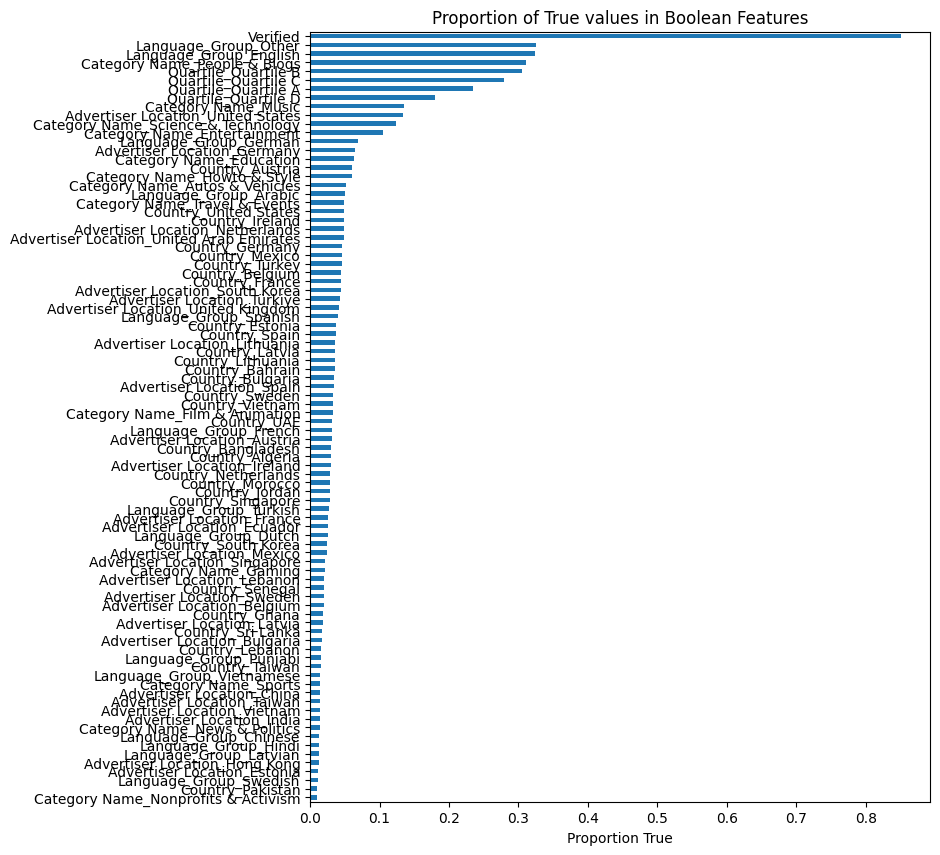

Dropping columns: []


In [40]:
bool_cols = df_encoded.select_dtypes(include=['bool']).columns
print("Boolean columns:", list(bool_cols))

for col in bool_cols:
    print(f"\n=== {col} ===")
    print(df_encoded[col].value_counts(normalize=True).rename("proportion"))

df_encoded[bool_cols].mean().sort_values().plot(kind='barh', figsize=(8,10))
plt.title("Proportion of True values in Boolean Features")
plt.xlabel("Proportion True")
plt.show()

# Find useless columns
useless_cols = [col for col in df_encoded.columns
                if df_encoded[col].value_counts(normalize=True).iloc[0] > 0.99]

print("Dropping columns:", useless_cols)

# Drop them
df_encoded.drop(columns=useless_cols, inplace=True)

In [41]:
df_encoded.shape
df_encoded.columns

Index(['Verified', 'target', 'Category Name_Autos & Vehicles',
       'Category Name_Education', 'Category Name_Entertainment',
       'Category Name_Film & Animation', 'Category Name_Gaming',
       'Category Name_Howto & Style', 'Category Name_Music',
       'Category Name_News & Politics', 'Category Name_Nonprofits & Activism',
       'Category Name_People & Blogs', 'Category Name_Science & Technology',
       'Category Name_Sports', 'Category Name_Travel & Events',
       'Country_Algeria', 'Country_Austria', 'Country_Bahrain',
       'Country_Bangladesh', 'Country_Belgium', 'Country_Bulgaria',
       'Country_Estonia', 'Country_France', 'Country_Germany', 'Country_Ghana',
       'Country_Ireland', 'Country_Jordan', 'Country_Latvia',
       'Country_Lebanon', 'Country_Lithuania', 'Country_Mexico',
       'Country_Morocco', 'Country_Netherlands', 'Country_Pakistan',
       'Country_Senegal', 'Country_Singapore', 'Country_South Korea',
       'Country_Spain', 'Country_Sri Lanka', 'Co

In [42]:
# Select numerical columns
num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns

# Process each numerical column
for col in num_cols:
    series = df_encoded[col]

    # Replace NaNs with mean
    mean_val = series.mean()
    df_encoded[col] = series.fillna(mean_val)

    # Compute IQR for outlier detection
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find the max and min values within non-outliers
    capped_min = series[series >= lower_bound].min()
    capped_max = series[series <= upper_bound].max()

    # Replace outliers
    df_encoded[col] = np.where(series < lower_bound, capped_min, series)
    df_encoded[col] = np.where(df_encoded[col] > upper_bound, capped_max, df_encoded[col])


In [43]:
plt.figure(figsize=(15, len(num_cols)*3))

for i, col in enumerate(num_cols, 1):
    if col == "target":
        continue
    plt.subplot(len(num_cols), 1, i)
    sns.violinplot(x=df_encoded[col], color='lightgreen')
    plt.title(f'Violin plot of {col}')

plt.tight_layout()
plt.show()

<Figure size 1500x300 with 0 Axes>

# Model

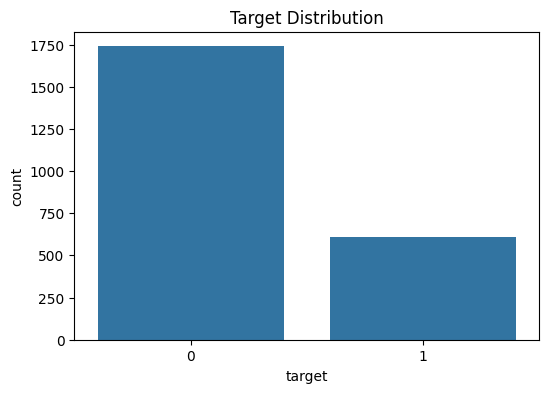

Counts:
 target
0    1739
1     609
Name: count, dtype: int64

Percentages:
 target
0    74.06
1    25.94
Name: proportion, dtype: float64


In [44]:
# --- Target Distribution (if labeled data) ---
if 'target' in df_encoded.columns:  # replace 'target' with your label column name
    plt.figure(figsize=(6,4))
    sns.countplot(x='target', data=df)
    plt.title("Target Distribution")
    plt.show()

counts = df_encoded['target'].value_counts()
percent = df_encoded['target'].value_counts(normalize=True) * 100

print("Counts:\n", counts)
print("\nPercentages:\n", percent.round(2))

In [45]:
df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
# Check for any NaNs
has_nan = df_encoded.isna().any().any()
print("Any NaNs in df?", has_nan)

# Check for any infinite values
has_inf = np.isinf(df_encoded.select_dtypes(include=[np.number])).any().any()
print("Any infinite values in df?", has_inf)


Any NaNs in df? False
Any infinite values in df? False


In [46]:
df_encoded.columns = [col.replace(" ", "_").replace(":", "_") for col in df_encoded.columns]
df_encoded.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in df_encoded.columns]
# Drop target
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

print(X.shape)
print(X.columns)

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

(2348, 88)
Index(['Verified', 'Category_Name_Autos___Vehicles', 'Category_Name_Education',
       'Category_Name_Entertainment', 'Category_Name_Film___Animation',
       'Category_Name_Gaming', 'Category_Name_Howto___Style',
       'Category_Name_Music', 'Category_Name_News___Politics',
       'Category_Name_Nonprofits___Activism', 'Category_Name_People___Blogs',
       'Category_Name_Science___Technology', 'Category_Name_Sports',
       'Category_Name_Travel___Events', 'Country_Algeria', 'Country_Austria',
       'Country_Bahrain', 'Country_Bangladesh', 'Country_Belgium',
       'Country_Bulgaria', 'Country_Estonia', 'Country_France',
       'Country_Germany', 'Country_Ghana', 'Country_Ireland', 'Country_Jordan',
       'Country_Latvia', 'Country_Lebanon', 'Country_Lithuania',
       'Country_Mexico', 'Country_Morocco', 'Country_Netherlands',
       'Country_Pakistan', 'Country_Senegal', 'Country_Singapore',
       'Country_South_Korea', 'Country_Spain', 'Country_Sri_Lanka',
       'C

# Baseline Model Comparison

In [47]:
# Define base classifiers
rf  = RandomForestClassifier(n_estimators=100,min_samples_leaf=2, random_state=42, n_jobs=-1)
hgb = HistGradientBoostingClassifier(max_iter=400, random_state=42)
et  = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
lr  = LogisticRegression(max_iter=1000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=20)
gnb = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

xgb = XGBClassifier(n_estimators=500, random_state=42, eval_metric='logloss')
lgbm = LGBMClassifier(n_estimators=500, random_state=42, verbose=-1)
cat  = CatBoostClassifier(iterations=500, random_state=42, verbose=0)

# Collect all classifiers in dictionary
classifiers = {
    'Random Forest': rf,
    'HistGradientBoosting': hgb,
    'ExtraTrees': et,
    'Logistic Regression': lr,
    'KNN': knn,
    'Naive Bayes': gnb,
    'MLP': mlp,
    'XGBoost': xgb,
    'LightGBM': lgbm,
    'CatBoost': cat,
}

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_results = {}
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    baseline_results[name] = (scores.mean(), scores.std())
    print(f"{name} | Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest | Accuracy: 0.8403 ± 0.0077
HistGradientBoosting | Accuracy: 0.8088 ± 0.0099
ExtraTrees | Accuracy: 0.8104 ± 0.0029
Logistic Regression | Accuracy: 0.8461 ± 0.0081
KNN | Accuracy: 0.8269 ± 0.0084
Naive Bayes | Accuracy: 0.6171 ± 0.0241


c:\Users\GNG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\GNG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\GNG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP | Accuracy: 0.8030 ± 0.0143
XGBoost | Accuracy: 0.8120 ± 0.0134
LightGBM | Accuracy: 0.8104 ± 0.0098
CatBoost | Accuracy: 0.8365 ± 0.0106



Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Params for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Accuracy: 0.8429

Tuning Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Accuracy: 0.8461

Tuning CatBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Params for CatBoost: {'depth': 10, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
Best CV Accuracy: 0.8419

=== Random Forest (Tuned) ===
              precision    recall  f1-score   support

           0     0.8400    0.9655    0.8984       348
           1     0.8286    0.4754    0.6042       122

    accuracy                         0.8383       470
   macro avg     0.8343    0.7205    0.7513       470
weighted avg     0.8370    0.8383    0.8220       470



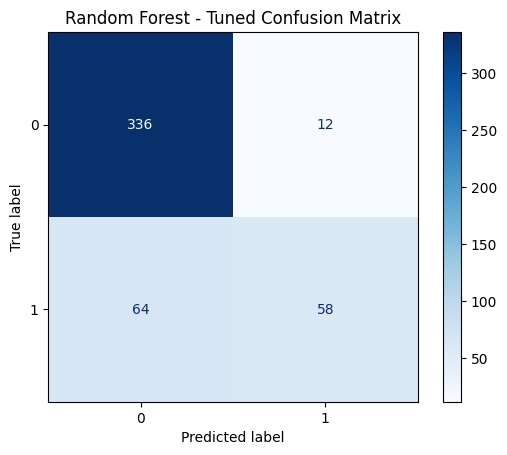


=== Logistic Regression (Tuned) ===
              precision    recall  f1-score   support

           0     0.8388    0.9569    0.8940       348
           1     0.7945    0.4754    0.5949       122

    accuracy                         0.8319       470
   macro avg     0.8167    0.7162    0.7444       470
weighted avg     0.8273    0.8319    0.8163       470



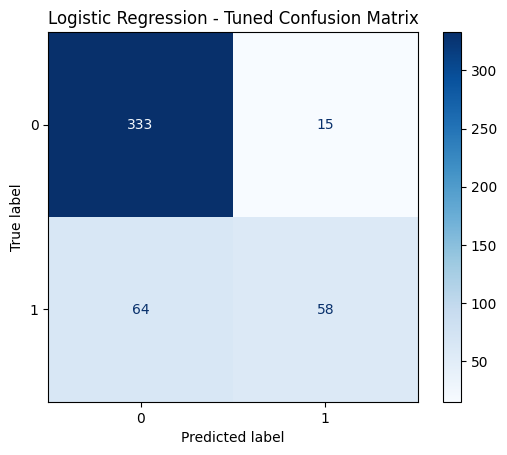


=== CatBoost (Tuned) ===
              precision    recall  f1-score   support

           0     0.8329    0.9741    0.8980       348
           1     0.8571    0.4426    0.5838       122

    accuracy                         0.8362       470
   macro avg     0.8450    0.7084    0.7409       470
weighted avg     0.8392    0.8362    0.8164       470



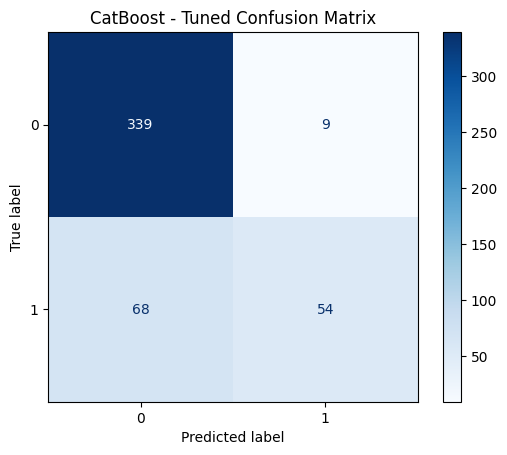

Saved Random Forest as models/best_model_Random_Forest.pkl
Saved Logistic Regression as models/best_model_Logistic_Regression.pkl
Saved CatBoost as models/best_model_CatBoost.pkl


In [50]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 400],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["lbfgs", "liblinear"],
        "penalty": ["l2"]
    },
    "CatBoost": {
        "depth": [6, 8, 10],
        "learning_rate": [0.01, 0.05, 0.1],
        "iterations": [300, 500],
        "l2_leaf_reg": [1, 3, 5]
    }
}

# Model mapping
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

best_models = {}

for name in ["Random Forest", "Logistic Regression", "CatBoost"]:
    print(f"\nTuning {name}...")
    grid = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Best CV Accuracy: {grid.best_score_:.4f}")
    best_models[name] = grid.best_estimator_

# Evaluate tuned models

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\n=== {name} (Tuned) ===")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(
        cmap="Blues", values_format="d")
    plt.title(f"{name} - Tuned Confusion Matrix")
    plt.show()

# Save the best 3 tuned models
for name, model in best_models.items():
    filename = f"models/best_model_{name.replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} as {filename}")

Saved plot at 600 dpi to: plots/Random Forest_feature_importances.png


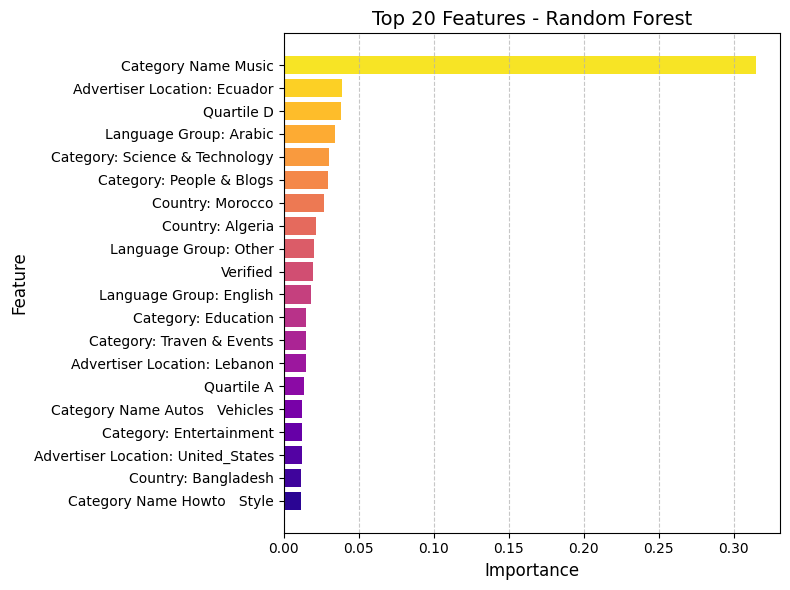

Saved plot at 600 dpi to: plots/Logistic Regression_feature_importances.png


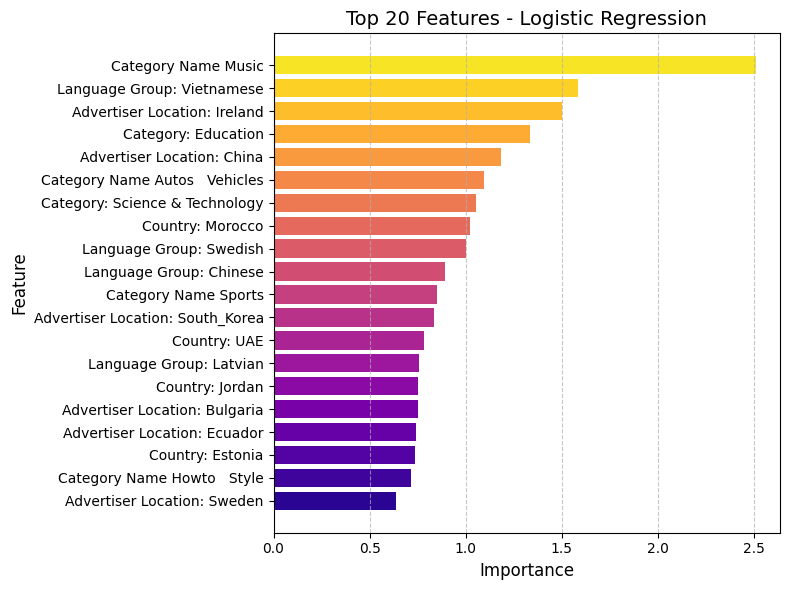

Saved plot at 600 dpi to: plots/CatBoost_feature_importances.png


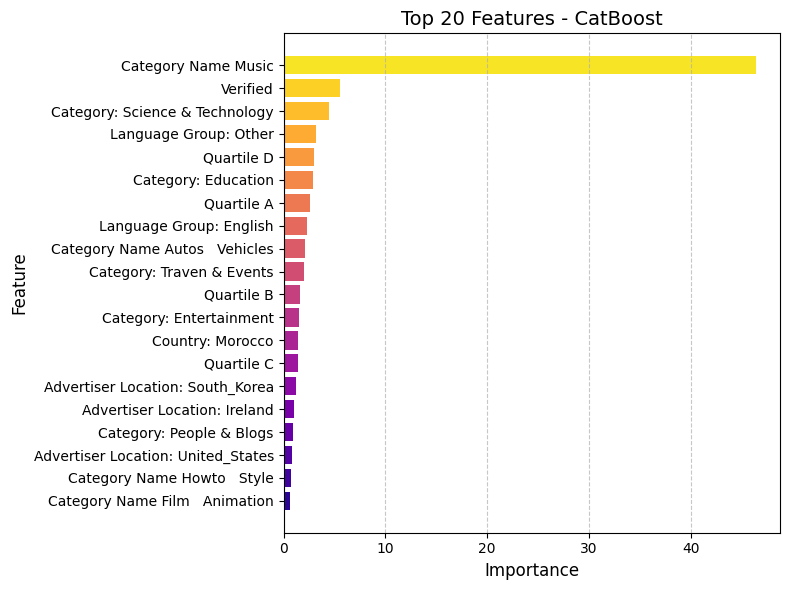

In [51]:
def clean_feature_name(feat):
    # Handle country/language/category one-hot
    if feat.startswith("Country_"):
        return "Country: " + feat.split("_", 1)[1]
    elif feat.startswith("Language_Group_"):
        return "Language Group: " + feat.split("_", 2)[2]  # to get actual language
    elif feat.startswith("Language_Group_Other"):
        return "Language Group: Other"
    elif feat.startswith("Advertiser_Location_"):
        return "Advertiser Location: " + feat.split("_", 2)[2]
    elif feat.startswith("Quartile_"):
        return feat.replace("_Quartile_", " ")
    elif feat == "Duration__seconds_":
        return "Ad Duration"
    elif feat == "Verified":
        return "Verified"
    elif feat.startswith("Category_Name_People___Blogs"):
        return "Category: People & Blogs"  # join rest
    elif feat.startswith("Category_Name_Science___Technology"):
        return "Category: Science & Technology"  # join rest
    elif feat.startswith("Category_Name_Travel___Events"):
        return "Category: Traven & Events" # join rest
    elif feat.startswith("Category_Name_Education"):
        return "Category: Education"   # join rest
    elif feat.startswith("Category_Name_Entertainment"):
        return "Category: Entertainment"   # join rest
    else:
        return feat.replace("_", " ")
    
rename_dict = {f: clean_feature_name(f) for f in X_train.columns}

def plot_importances(model, name, rename_dict=None, top_n=20, palette="plasma", save_path=None):
    """Plot top N feature importances with a specified color palette and optional save at high dpi."""
    
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.mean(np.abs(model.coef_), axis=0)
    else:
        print(f"{name}: no feature importances available.")
        return
    
    feature_names = np.array(X_train.columns) if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])
    
    if rename_dict:
        feature_names = np.array([rename_dict.get(f, f) for f in feature_names])
    
    idx = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(8, 6))
    colors = sns.color_palette(palette, top_n)
    bars = plt.barh(feature_names[idx][::-1], importances[idx][::-1], color=colors)
    
    # for bar in bars:
    #     width = bar.get_width()
    #     plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center', fontsize=9)
    
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.title(f"Top {top_n} Features - {name}", fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"Saved plot at 600 dpi to: {save_path}")
    
    plt.show()

# Example usage
for name, model in best_models.items():
    if not hasattr(model, "feature_importances_") and not hasattr(model, "coef_"):
        print(f"{name}: feature importances not supported.")
        continue
    plot_importances(
        model, 
        name, 
        rename_dict=rename_dict, 
        palette="plasma", 
        save_path=f"plots/{name}_feature_importances.png"  # saved in 'plots' folder
    )



=== Stacking Classifier (Tuned Top 3 + MLP Meta) ===
              precision    recall  f1-score   support

           0     0.8358    0.9655    0.8960       348
           1     0.8235    0.4590    0.5895       122

    accuracy                         0.8340       470
   macro avg     0.8297    0.7123    0.7427       470
weighted avg     0.8326    0.8340    0.8164       470



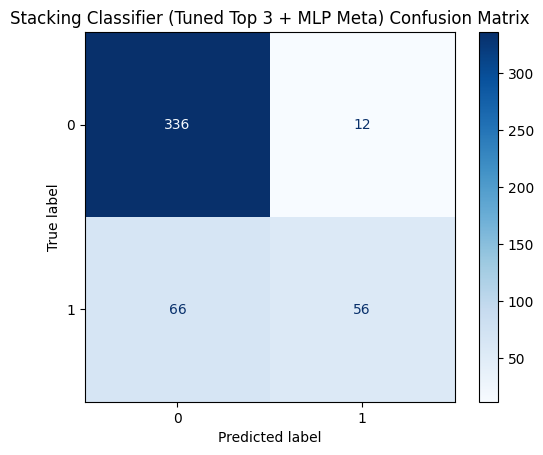

In [ ]:
# Base estimators (tuned top 3)
estimators = [
    ("Random Forest", best_models["Random Forest"]),
    ("Logistic Regression", best_models["Logistic Regression"]),
    ("CatBoost", best_models["CatBoost"])
]

# Meta-learner (MLP)
meta_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=1000,
    random_state=42
)

# Stacking classifier
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=False,
    n_jobs=-1
)

# Train and evaluate
stack_clf.fit(X_train, y_train)
y_pred = stack_clf.predict(X_test)

print("=== Stacking Classifier (Tuned Top 3 + MLP Meta) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack_clf.classes_).plot(
    cmap='Blues', values_format='d')
plt.title("Stacking Classifier (Tuned Top 3 + MLP Meta) Confusion Matrix")
plt.show()
